# Deploying and Using MedImageParse model for Inference using Online Endpoints
This example illustrates how to deploy MedImageParse, a state-of-the-art segmentation model tailored for biomedical imaging. For this Notebook, we use Python 3.10, AzureML v2.

### Task
The primary task is semantic segmentation, where the goal is to identify and label specific regions within an image based on their semantic meaning using a submitted image and a text prompt.
 
### Model
MedImageParse is powered by a transformer-based architecture, fine-tuned for segmentation tasks on extensive biomedical image datasets. It is designed to excel in handling complex segmentation challenges across diverse imaging modalities. 

### Inference data
For this demonstration, we will use histopathology images stained with HE (Hematoxylin and Eosin) and focus on cell phenotyping, segmenting and identifying different types of cells in the tissue sample.

### Outline
1. Setup pre-requisites
2. Pick a model to deploy
3. Deploy the model to an online endpoint
4. Test the endpoint
5. Clean up resources - delete the endpoint

## 1. Setup pre-requisites
* Install [Azure ML Client library for Python](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-ml-readme?view=azure-python)
* Connect to AzureML Workspace and authenticate.

In [1]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    InteractiveBrowserCredential,
)
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
)

try:
    credential = DefaultAzureCredential()
except Exception as ex:
    credential = InteractiveBrowserCredential()

## 2. Pick a model to deploy

In this example, we use the `MedImageParse` model. If you have opened this notebook for a different model, replace the model name accordingly.

In [2]:
# The models are available in the AzureML system registry, "azureml"
registry_ml_client = MLClient(
    credential,
    registry_name="azureml",
)
model = registry_ml_client.models.get(name="MedImageParse", label="latest")
ml_client = MLClient.from_config(credential)

Found the config file in: /mnt/c/medimagingai/config.json


## 3. Deploy the model to an online endpoint for real time inference
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

The steps below show how to deploy an endpoint programmatically. You can skip the steps in this section if you just want to test an existing endpoint. 

In [3]:
import random
import string

endpoint_name = "MedImageParse"

# Creating a unique endpoint name by including a random suffix
allowed_chars = string.ascii_lowercase + string.digits
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))
endpoint_name = f"{endpoint_name}-{endpoint_suffix}"

print(f"Endpoint name: {endpoint_name}")

Endpoint name: MedImageParse-plzac


In [4]:
endpoint = ManagedOnlineEndpoint(name=endpoint_name)
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [5]:
from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "medimageparse-v2"
deployment_package = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model,
    instance_type="Standard_NC6s_v3",
    instance_count=1,
    request_settings=OnlineRequestSettings(request_timeout_ms=90000),
    app_insights_enabled=True,
    liveness_probe=ProbeSettings(initial_delay=600),
)

In [6]:
_ = ml_client.online_deployments.begin_create_or_update(deployment_package).result()

Check: endpoint MedImageParse-plzac exists


.............................................................................................................................................................................................

## 4 Test the endpoint - base64 encoded image and text
We will use one digital pathology image to test the endpoint it will be located in the 'images' directory.

**Download the sample data**:  
   - Use the following command to download the dataset with samples into your working folder. Once you download, make sure the files are in the `./images` directory located in the same directory as this notebook so that all paths in this sample work out of the box.  

      `azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/medimageparse-images/* ./images`

In [7]:
# If you skipped the programmatic deployment step, and just want to test the endpoint that you already have, you can uncomment the strings below and add your endpoint and deployment names.
# endpoint_name = ""
# deployment_name = ""

In [8]:
import json
import base64
import matplotlib.pyplot as plt


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


sample_image = "./images/pathology_breast.png"
data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [
                base64.encodebytes(read_image(sample_image)).decode("utf-8"),
                "neoplastic cells in breast pathology & inflammatory cells",
            ]
        ],
    }
}
data_json = json.dumps(data)

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(data, request_file)

In [ ]:
import numpy as np
import json


def decode_json_to_array(json_encoded):
    """Decode an image pixel data array in JSON.
    Return image pixel data as an array.
    """
    # Parse the JSON string
    array_metadata = json.loads(json_encoded)
    # Extract Base64 string, shape, and dtype
    base64_encoded = array_metadata["data"]
    shape = tuple(array_metadata["shape"])
    dtype = np.dtype(array_metadata["dtype"])
    # Decode Base64 to byte string
    array_bytes = base64.b64decode(base64_encoded)
    # Convert byte string back to NumPy array and reshape
    array = np.frombuffer(array_bytes, dtype=dtype).reshape(shape)
    return array


def plot_segmentation_masks(original_image, segmentation_masks):
    """Plot a list of segmentation mask over an image."""
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")

    for i, mask in enumerate(segmentation_masks):
        ax[i + 1].imshow(original_image)
        ax[i + 1].set_title(f"Mask {i+1}")
        mask_temp = original_image.copy()
        mask_temp[mask > 128] = [255, 0, 0, 255]
        mask_temp[mask <= 128] = [0, 0, 0, 0]
        ax[i + 1].imshow(mask_temp, alpha=0.9)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


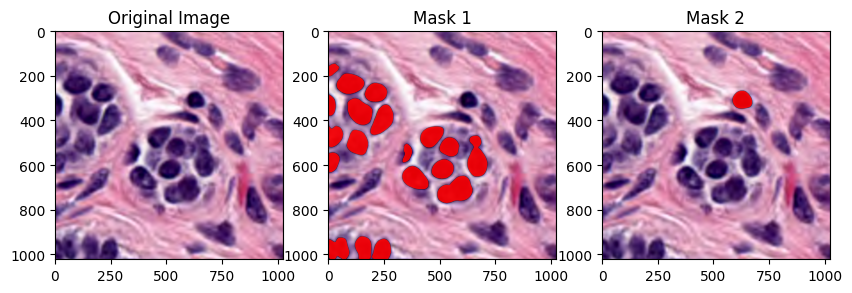

In [10]:
# Score the sample_score.json file using the online endpoint with the azureml endpoint invoke method
response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
result_list = json.loads(response)
image_features_str = result_list[0]["image_features"]
image_features = decode_json_to_array(image_features_str)

# Plot feature over image
sample_image_arr = plt.imread(sample_image)
plot_segmentation_masks(sample_image_arr, image_features)

## 5. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [ ]:
ml_client.online_endpoints.begin_delete(name=endpoint_name).wait()